In [15]:
#导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
#解决中文显示问题
# Solve Chinese display issue (set font)
rcParams['font.sans-serif'] = 'SimHei'
rcParams['axes.unicode_minus'] = False
#读取数据
#Read dataset
df = pd.read_csv('industrial_data_1000.csv')
print('数据集前五行:')
print(df.head())

数据集前五行:
   Temperature     Voltage  Pressure  Vibration        Speed  Anomaly
0    64.967142  226.996777  4.324822   0.138289  1240.951919        0
1    58.617357  224.623168  4.855481   1.709422  1490.638953        0
2    66.476885  220.298152  4.207580   2.379592  1505.405062        0
3    75.230299  216.765316  4.692038   5.831531  1641.789104        0
4    57.658466  223.491117  3.106385   3.834830  1089.942491        0


In [16]:
#缺失值检测
#Check for missing values
print('\n缺失值统计：')
print(df.isnull().sum())


缺失值统计：
Temperature    0
Voltage        0
Pressure       0
Vibration      0
Speed          0
Anomaly        0
dtype: int64


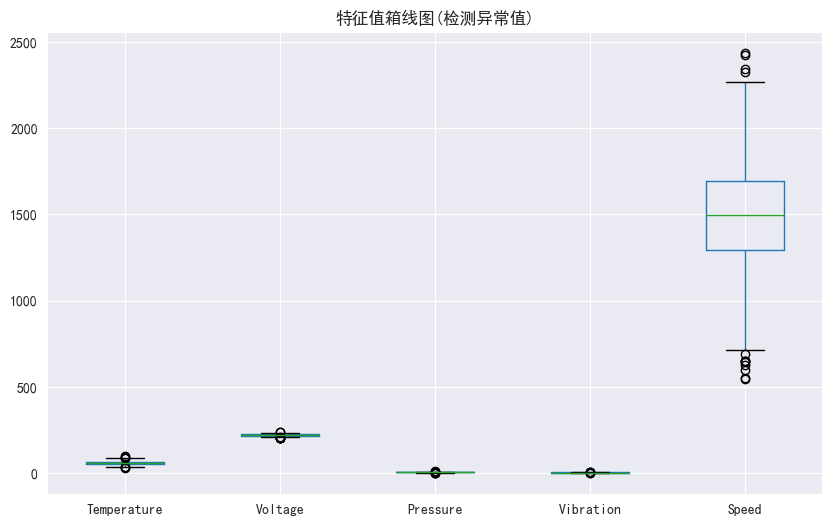

In [17]:
#异常值检测（箱线图法）
#Outlier detection (Boxplot method)
features = ['Temperature','Voltage','Pressure','Vibration','Speed']
plt.figure(figsize=(10,6))
df[features].boxplot()
plt.title('特征值箱线图(检测异常值)')
plt.show()


In [18]:
#异常值检测函数(基于IQR法)
#Outlier detection function based on IQR method
def detect_outliers(series):
    Q1 = series.quantile(0.25) 
    Q3 = series.quantile(0.75) 
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)
# 针对每个特征检测异常值，输出异常数量和索引
# Detect outliers for each feature and print count and indices
for feature in features:
    outliers = detect_outliers(df[feature])
    print(f'{feature}异常值数量 / Number of outliers: {outliers.sum()}')
    print(f'{feature}异常值索引 / Outlier indices: {df.index[outliers].tolist()}')


Temperature异常值数量 / Number of outliers: 8
Temperature异常值索引 / Outlier indices: [74, 179, 209, 262, 478, 646, 668, 755]
Voltage异常值数量 / Number of outliers: 8
Voltage异常值索引 / Outlier indices: [61, 101, 539, 591, 615, 750, 957, 971]
Pressure异常值数量 / Number of outliers: 10
Pressure异常值索引 / Outlier indices: [24, 35, 305, 506, 521, 556, 801, 884, 895, 947]
Vibration异常值数量 / Number of outliers: 5
Vibration异常值索引 / Outlier indices: [152, 241, 454, 716, 982]
Speed异常值数量 / Number of outliers: 13
Speed异常值索引 / Outlier indices: [6, 33, 47, 198, 207, 617, 635, 639, 725, 779, 784, 870, 997]


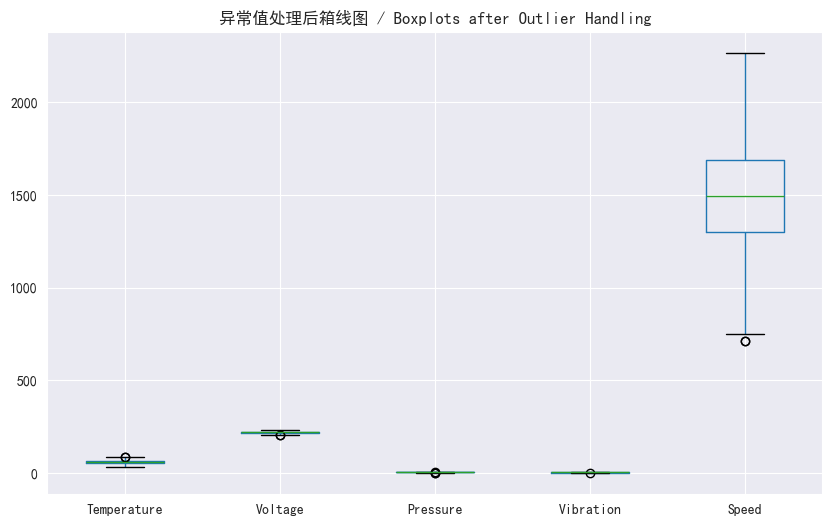


处理后缺失值统计 / Missing values after cleaning:
Temperature    0
Voltage        0
Pressure       0
Vibration      0
Speed          0
Anomaly        0
dtype: int64


In [19]:
#异常值处理，用中位数替换异常值
#Handle outliers by replacing them with median values

df_clean = df.copy()

# 遍历每个特征列，找到异常值并替换成该列中位数
# For each feature, find outliers and replace them with the median of the feature
for feature in features:
    # 计算中位数
    median = df_clean[feature].median()
    # 检测异常值布尔索引
    outliers = detect_outliers(df_clean[feature])
    # 用中位数替换异常值
    df_clean.loc[outliers, feature] = median

# 查看处理后的数据的箱线图
# Plot boxplots of cleaned data to verify outlier handling
plt.figure(figsize=(10,6))
df_clean[features].boxplot()
plt.title('异常值处理后箱线图 / Boxplots after Outlier Handling')
plt.show()

# 显示处理后数据的缺失值统计（应该为0）
# Show missing value count after processing (should be zero)
print('\n处理后缺失值统计 / Missing values after cleaning:')
print(df_clean.isnull().sum())


训练集大小 / Train set size: (800, 5)
测试集大小 / Test set size: (200, 5)
模型准确率 / Model Accuracy: 0.96

分类报告 / Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       160
           1       1.00      0.82      0.90        40

    accuracy                           0.96       200
   macro avg       0.98      0.91      0.94       200
weighted avg       0.97      0.96      0.96       200



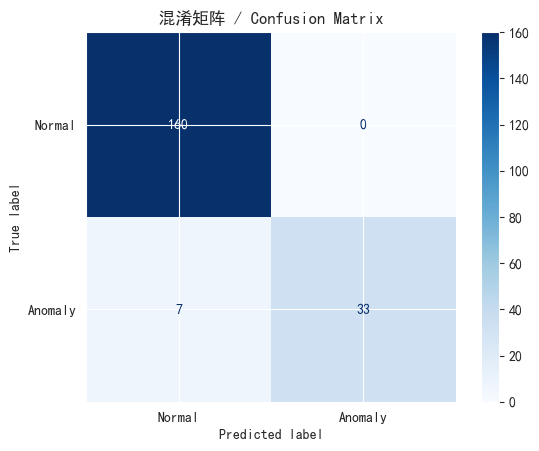

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#拆分数据集为训练集和测试集
#Split the dataset into training set and test set
X = df_clean[features]  # 特征数据 Features
y = df_clean['Anomaly']  # 标签列，假设叫Anomaly，0-正常，1-异常 Label column (0-normal, 1-anomaly)

# 拆分，80%训练，20%测试，设置随机种子保证结果复现
# Split data: 80% train, 20% test, random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'训练集大小 / Train set size: {X_train.shape}')
print(f'测试集大小 / Test set size: {X_test.shape}')

# 创建随机森林分类模型
# Create Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# 用训练集训练模型
# Train model with training data
rf_model.fit(X_train, y_train)

# 用测试集预测标签
# Predict on test data
y_pred = rf_model.predict(X_test)

# 计算准确率
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'模型准确率 / Model Accuracy: {accuracy:.2f}')

# 输出分类报告（包含精准率、召回率、F1分数等）
# Print classification report (precision, recall, f1-score)
print('\n分类报告 / Classification Report:')
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('混淆矩阵 / Confusion Matrix')
plt.show()

SVM模型准确率 (Accuracy): 0.82

分类报告 / Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       160
           1       0.58      0.35      0.44        40

    accuracy                           0.82       200
   macro avg       0.72      0.64      0.67       200
weighted avg       0.80      0.82      0.80       200



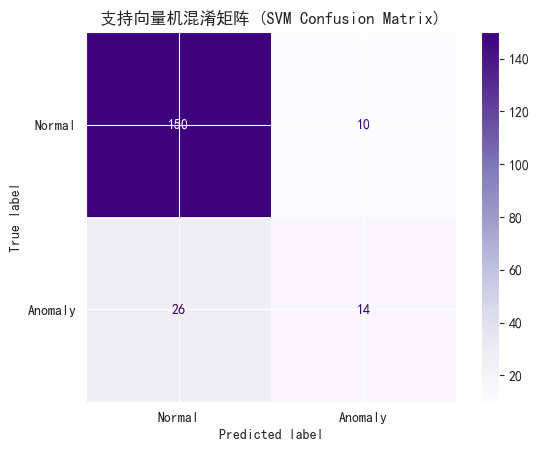

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 创建支持向量机模型，kernel='rbf'为常用核函数
# Create SVM model with RBF kernel
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# 用训练集训练模型
# Train the model on training data
svm_model.fit(X_train, y_train)

# 用测试集做预测
# Predict on test data
y_pred_svm = svm_model.predict(X_test)

# 输出准确率
# Print accuracy score
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM模型准确率 (Accuracy): {acc_svm:.2f}')

# 输出分类报告
# Print detailed classification report
print('\n分类报告 / Classification Report:')
print(classification_report(y_test, y_pred_svm))

# 生成混淆矩阵
# Generate confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# 可视化混淆矩阵
# Visualize confusion matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Normal', 'Anomaly'])
disp_svm.plot(cmap=plt.cm.Purples)
plt.title('支持向量机混淆矩阵 (SVM Confusion Matrix)')
plt.show()